<a href="https://colab.research.google.com/github/SamuelFoo/ML/blob/master/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

!curl -s https://course.fast.ai/setup/colab | bash

from fastai import *
from fastai.text import *
import pickle

# To consider:
# Momentum
# Reduce Batch size
# Try freezing and unfreezing for language model
# Start from freeze_to(-1)

Updating fastai...
Done.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/ML/NLP/"

Mounted at /content/gdrive


In [ ]:
train = pd.read_csv(root_dir+"TIL_NLP_train_dataset.csv")
print(len(train))
train.head(10)

7380


,id,word_representation,outwear,top,trousers,women dresses,women skirts
0,0,w7718 w173355 w138132 w232277 w90685 w314686 w...,1,0,1,0,0
1,1,w195317 w127737 w171593 w22890 w342007 w217871...,1,0,1,0,0
2,2,w247655 w270233 w261113 w337250 w366000 w37873...,0,1,1,0,0
3,3,w279289 w395855 w61795 w286461 w308610 w27013 ...,1,0,1,0,0
4,4,w254516 w135431 w115724 w331534 w256214 w71240...,1,0,1,0,0
5,5,w53495 w306061 w372126 w47982 w66980 w189406 w...,1,0,0,0,1
6,6,w237465 w256553 w286461 w382662 w206066 w12125...,1,0,0,1,0
7,7,w173317 w39222 w207614 w136665 w394246 w197783...,1,1,1,0,0
8,8,w373517 w37419 w358253 w162965 w286461 w204762...,1,0,0,0,0
9,9,w230409 w109269 w369689 w186076 w377961 w21787...,1,1,0,0,0


In [ ]:
test = pd.read_csv(root_dir+"TIL_NLP_test_dataset.csv")
print(len(test))
test.head(10)

2460


,id,word_representation
0,0,w373517 w383437 w374393 w87179 w289496 w327385...
1,1,w237465 w167111 w279437 w194870 w351537 w17560...
2,2,w151648 w93366 w121255 w193800 w71240 w48576 w...
3,3,w182664 w317736 w33852 w111248 w45374 w209361 ...
4,4,w206647 w236725 w99560 w338476 w75409 w36882 w...
5,5,w256553 w182887 w239430 w96414 w276473 w217871...
6,6,w305957 w254429 w215751 w155034 w287643 w45765...
7,7,w318673 w350483 w356690 w186076 w151648 w34893...
8,8,w500001 w128292 w253354 w254516 w102910 w37439...
9,9,w41024 w237465 w95569 w174897 w103096 w237465 ...


In [ ]:
with open(root_dir+"word_embeddings.pkl", 'rb') as pickle_file:
  content = pickle.load(pickle_file)

In [ ]:
# Create databunch
comb = train.append(test) # Use combined df for lm
data = (TextList.from_df(comb, cols='word_representation')
                .split_by_rand_pct(0.1)
                .label_for_lm()  
                .databunch(bs=64))
data.show_batch()

idx,text
0,w71240 w356796 w326106 w34893 w175250 w217578 w186076 w349078 xxunk w241910 xxbos w53495 w306061 w372126 w47982 w66980 w189406 w71392 w217871 w127234 w301260 w51947 w336335 w217871 xxunk w500123 w221983 w103141 w105773 w318673 w380347 w201668 xxbos w173317 w39222 w207614 w136665 w394246 w197783 w193800 w500179 w66980 w392147 w373260 w322219 w245476 w52265 w217871 w30555 w296675 w207614 w34893 w113598 w338587 w267311 w186076 w222433 w34893 w383444 w115724 w71240 w311583 w89538 w317619 w112319 w165609 w173915 w314686 xxbos w373517
1,w83749 w256553 w218713 w286461 w221980 w230729 w111248 w181937 w22890 w121735 w356891 w250138 w373432 w323852 xxbos w237465 w53495 w372126 w47982 w66980 w189406 w71392 w217871 w127234 w141635 w339993 w221983 w217871 w204762 w150363 w381605 w264611 w209018 w177163 w342007 w103141 w318673 w45021 w380347 w201668 xxbos w142023 w186076 w309049 w373517 w6691 w275199 w374393 w286461 w62861 w500121 w135270 w51947 w111939 w186076 w5713 w195317 w356690 w398645 w286461 w198149 w135431 w288596 w155411 w257531 w48776 w171593 w197783 xxbos w112319
2,w29840 w12175 w314686 xxbos w386891 w391558 w5 xxrep 4 0 2 w374574 w127737 w286083 w8992 w197783 w193800 w74022 w117890 w217871 w389043 w1867 w120979 w105773 w194870 w217871 w34893 w87179 w289496 w312826 w319927 w22890 w392167 xxbos w112474 w198528 w250138 w311583 w368918 w261297 w28646 w239430 w241910 w70293 w194427 w311215 w42169 w256897 w270233 w33502 w269165 w82341 w370005 w66217 xxbos w386891 w391558 w5 xxrep 4 0 2 w374574 w34893 w286083 w8992 xxunk w221983 w105773 w12216
3,w39302 w118624 w314686 w186076 w399290 w194870 w52572 w253354 w500525 w164871 w371438 w392167 xxbos w5797 w374393 w83112 w286461 w71392 w253067 w69002 w256214 w71240 w311583 w115724 w500211 w36882 w395855 w218713 w243012 w10271 xxbos w194870 w39947 w164832 w203992 w105773 w194870 w286461 w111498 w286083 w253067 w193800 w116749 w500060 w221496 w202359 w165609 w314686 xxbos w44401 w94172 w136665 w307868 w120979 w9294 w267864 w500021 w70293 w194427 w311215 w5348 w42169 w256897 w270233 w33502 w269165 w82341 w66217 xxbos w142023
4,w186076 w337250 w349078 w204762 w150422 w500384 xxunk w1867 w338476 w36882 xxbos w318673 w80884 w385278 w34893 w121255 w42500 w186076 w327774 w34893 xxunk w221983 w143460 w39222 w311583 w318673 w87179 w10065 w399365 w161756 w68334 w382659 w221983 xxbos w155034 w256553 w111248 w376233 w70856 w250138 w186076 w240587 w334524 w207614 w101837 w70856 w82660 w280823 w286297 w250138 w186076 w240587 xxbos w7678 w198528 w380494 w221983 w144920 w187552 w197783 w193800 w94172 w120979 w70293 w194427 w5348 w42169 w256897 w270233 w33502


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


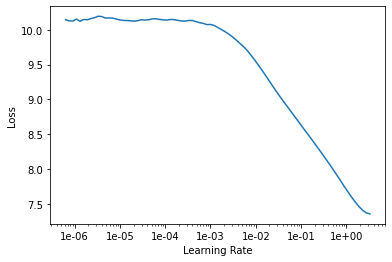

In [ ]:
learn = language_model_learner(data,AWD_LSTM, drop_mult=0.3)

# select the appropriate learning rate
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.save("zero")

In [ ]:
learn.load("zero")
learn.fit_one_cycle(13, 1e-2, moms=(0.8, 0.7))
# learn.save_encoder('fine_tuned_enc')

epoch,train_loss,valid_loss,accuracy,time
0,8.475259,6.767423,0.052054,00:03
1,6.924409,5.817599,0.100580,00:03
2,5.933507,4.453745,0.244732,00:03
3,4.659141,3.182629,0.451518,00:03
4,3.713822,2.801981,0.497813,00:03
5,3.136292,2.624682,0.521384,00:03
6,2.771492,2.521738,0.533036,00:03
7,2.537674,2.454271,0.543170,00:03
8,2.376188,2.409844,0.547768,00:03
9,2.268250,2.383321,0.553661,00:03


In [ ]:
# learn.save_encoder('fine_tuned_enc')
# learn.save("lm")

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(10, slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))
# learn.save_encoder('fine_tuned_enc')

epoch,train_loss,valid_loss,accuracy,time
0,2.085057,2.359607,0.556652,00:04
1,2.076278,2.343947,0.559955,00:04
2,2.066374,2.326562,0.562723,00:04
3,2.038255,2.316863,0.564107,00:04
4,2.014101,2.301111,0.566205,00:04
5,1.997233,2.292094,0.567366,00:04
6,1.975109,2.291029,0.567366,00:04
7,1.959458,2.283796,0.567634,00:04
8,1.948042,2.282850,0.568705,00:04
9,1.939695,2.284847,0.568170,00:04


In [ ]:
label_cols = ["outwear","top","trousers","women dresses","women skirts"]

test_datalist = TextList.from_df(test, cols='word_representation', vocab=data.vocab)

data_clas = (TextList.from_df(train, cols='word_representation', vocab=data.vocab)
             .split_by_rand_pct(0.1)
             .label_from_df(cols= label_cols , classes=label_cols)
             .add_test(test_datalist)
             .databunch(bs=32))

data_clas.show_batch()

text,target
xxbos w173317 w39222 w207614 w93366 w230346 w323671 xxunk w137804 w279750 w500344 w294820 w33992 w66980 w392147 w373260 w322219 w245476 w52265 w217871 w296675 w207614 w34893 w113598 w338587 w267311 w186076 w222433 w34893 w341569 w204762 w101681 w175395 w115724 w266998 w171593 w36882 w384336 w311583 w89538 w236725 w66980 w384336 w192814 w193067 w311583 w241910 w113637,top;trousers
xxbos w39222 w207614 w553 w225970 w71958 w121255 w314686 w66980 w392147 w373260 w322219 w245476 w52265 w217871 w30555 w296675 w207614 w34893 w113598 w267311 w186076 w222433 w34893 w341569 w382662 w79536 w97882 w26335 w208909 w255331 w12685 w311583 w89538 w237221 w286596 w54702 w3 xxrep 4 2 4 w325608,trousers
xxbos w173317 w39222 w553 w230707 w368487 w303707 w92187 w314686 w66980 w392147 w373260 w322219 w52265 w217871 w30555 w296675 w207614 w34893 w113598 w338587 w267311 w186076 w222433 w34893 w341569 w378592 w234583 w101837 w155411 w294820 w33992 w311583 w89538 w280631 w198528 w29840 w345757 w1867 w120979,top;trousers
xxbos w173317 w39222 w553 w380347 w115724 w288320 w151045 w116057 w66980 w392147 w373260 w322219 w245476 w52265 w217871 w30555 w296675 w207614 w34893 w338587 w267311 w186076 w222433 w34893 w341569 w204762 w101681 w314861 w194870 w398740 w338476 w75409 w256214 w71240 w34893 w89538 w223408 w116919 w241910,outwear;trousers
xxbos w119784 w194870 w31180 w131051 w126729 w269012 w90685 w195317 w53573 w253354 w186076 w41128 w373517 w294269 w78494 w238644 w174897 w240625 w34893 w173688 w384021 w342007 w311583 w219120 w100269 w101837 w105773 w279541 w261801 w253067 w311583 w373517 w314861 w399365 w398740 w282700 w395984 w138132 w342007,outwear


epoch,train_loss,valid_loss,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-01
Min loss divided by 10: 5.25E-02


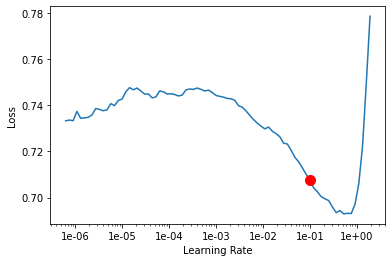

In [ ]:
f_score = partial(fbeta, thresh=0.2)

learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=f_score)

# load the encoder saved  
learn_classifier.load_encoder('fine_tuned_enc')
learn_classifier.freeze()

# select the appropriate learning rate
learn_classifier.lr_find()

# we typically find the point where the slope is steepest
learn_classifier.recorder.plot(suggestion=True)

In [ ]:
# Fit the model based on selected learning rate
learn_classifier.fit_one_cycle(10, 3e-2, moms=(0.8, 0.7))
learn_classifier.save('first')

epoch,train_loss,valid_loss,fbeta,time
0,0.462775,0.392814,0.825306,00:05
1,0.434341,0.366560,0.840220,00:05
2,0.432712,0.404356,0.820677,00:05
3,0.425945,0.355519,0.845655,00:05
4,0.421667,0.367964,0.839191,00:06
5,0.418203,0.353107,0.844019,00:05
6,0.402038,0.355417,0.849268,00:05
7,0.392805,0.342472,0.852166,00:05
8,0.384236,0.341795,0.849107,00:05
9,0.380464,0.409991,0.849580,00:05


In [ ]:
learn_classifier.load('first')
learn_classifier.freeze_to(-2)
learn_classifier.fit_one_cycle(10, slice(1e-2/(2.6**4), 1e-2), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,fbeta,time
0,0.370167,0.312809,0.856794,00:06
1,0.324938,0.261370,0.886500,00:06
2,0.282953,0.207004,0.905902,00:06
3,0.224467,0.152374,0.938901,00:06
4,0.182805,0.125756,0.944960,00:06
5,0.151158,0.109936,0.953744,00:06
6,0.140114,0.102484,0.958074,00:06
7,0.120717,0.098172,0.957739,00:06
8,0.117198,0.099292,0.957117,00:07
9,0.108886,0.098019,0.958548,00:06


In [ ]:
learn_classifier.save('second')

In [ ]:
learn_classifier.load('second')
learn_classifier.fit_one_cycle(5, slice(1e-2/(2.6**4), 1e-2), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,fbeta,time
0,0.112516,0.083000,0.967036,00:10
1,0.097905,0.057873,0.976724,00:11
2,0.070906,0.050292,0.980891,00:10
3,0.050654,0.047703,0.981723,00:11
4,0.036940,0.046503,0.981453,00:10


In [ ]:
learn_classifier.save('second')

In [ ]:
learn_classifier.load('second')
learn_classifier.freeze_to(-3)
learn_classifier.fit_one_cycle(10, slice(5e-3/(2.6**4), 5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,fbeta,time
0,0.041620,0.046279,0.982157,00:10
1,0.036748,0.047496,0.982606,00:10
2,0.039979,0.064553,0.982904,00:10
3,0.041923,0.055371,0.984109,00:11
4,0.043463,0.055591,0.985052,00:10
5,0.029758,0.048961,0.986401,00:11
6,0.027974,0.052501,0.983359,00:10
7,0.030503,0.053450,0.985391,00:10
8,0.025145,0.055832,0.984053,00:11
9,0.023962,0.055216,0.985213,00:11


In [ ]:
learn_classifier.save('third')

epoch,train_loss,valid_loss,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 4.37E-06


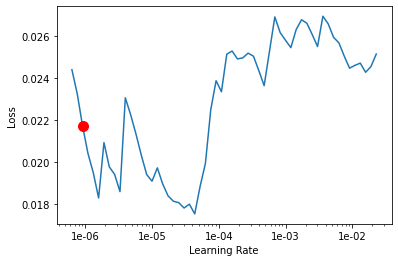

In [ ]:
learn_classifier.load('third')
learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

In [ ]:
learn_classifier.save('third_lr')

Build on

In [ ]:
from fastai.callbacks import *
# learn_classifier.load_encoder("fine_tuned_enc")
learn_classifier.callbacks = []
learn_classifier.freeze_to(-3)
learn_classifier.load('bestmodel')
learn_classifier.fit_one_cycle(10, slice(1e-6/(2.6**4), 1e-6), moms=(0.8, 0.7),
                               callbacks=[SaveModelCallback(learn_classifier, 'fbeta', name="fourth")])


In [ ]:
from fastai.callbacks import *
learn_classifier.fit_one_cycle(10, slice(1e-6/(2.6**4), 1e-6), moms=(0.8, 0.7),
                               callbacks=[SaveModelCallback(learn_classifier, 'fbeta', name="fourth")])

epoch,train_loss,valid_loss,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 5.25E-02


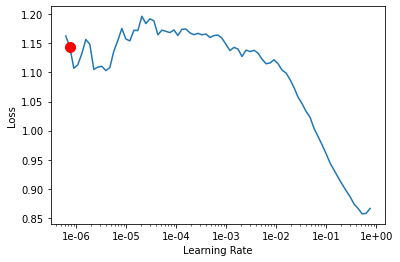

In [ ]:
learn_classifier.load("bestmodel")
learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

In [ ]:
learn_classifier.load('bestmodel')
learn_classifier.fit_one_cycle(10, slice(3e-6/(2.6**4), 3e-6), moms=(0.8, 0.7),
                               callbacks=[SaveModelCallback(learn_classifier, 'fbeta', name="fourth")])

epoch,train_loss,valid_loss,fbeta,time
0,0.027038,0.052758,0.984556,00:05
1,0.020336,0.053138,0.985241,00:05
2,0.023503,0.052449,0.984987,00:05
3,0.021956,0.050914,0.986979,00:05
4,0.021924,0.090270,0.986256,00:06
5,0.019315,0.051742,0.986322,00:05
6,0.024588,0.051425,0.985042,00:05
7,0.022643,0.085275,0.986265,00:05
8,0.029593,0.052759,0.985590,00:05
9,0.031673,0.053947,0.985681,00:05


Better model found at epoch 0 with fbeta value: 0.9845561385154724.
Better model found at epoch 1 with fbeta value: 0.9852405786514282.
Better model found at epoch 3 with fbeta value: 0.9869788289070129.


In [ ]:
learn_classifier.load('bestmodel')

functools.partial(<function fbeta at 0x7f2c09f46510>, thresh=0.2)

In [ ]:
learn_classifier.load('third')
learn_classifier.freeze_to(-4)
learn_classifier.fit_one_cycle(5, slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,fbeta,time
0,0.047955,0.060274,0.976620,00:14
1,0.046684,0.059701,0.977265,00:13
2,0.042456,0.060986,0.977665,00:14
3,0.035784,0.058694,0.977450,00:13
4,0.040259,0.058379,0.979104,00:13


In [ ]:
learn_classifier.fit_one_cycle(8, slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,fbeta,time
0,0.035244,0.057273,0.977559,00:13
1,0.037030,0.057522,0.977709,00:13
2,0.043070,0.055931,0.979735,00:13
3,0.032964,0.056663,0.979718,00:13
4,0.036123,0.055600,0.980221,00:13
5,0.031733,0.056561,0.979457,00:13
6,0.034066,0.055417,0.981670,00:13
7,0.032138,0.058793,0.981262,00:13


In [ ]:
learn_classifier.save('fourth')

In [ ]:
learn_classifier.load('bestmodel')
learn_classifier.show_results()

In [ ]:
preds, target = learn_classifier.get_preds(DatasetType.Test, ordered=True)
labels = preds.numpy()

test_id = test['id']
submission = pd.DataFrame({'id': test_id})
submission = pd.concat([submission, pd.DataFrame(preds.numpy(), columns = label_cols)], axis=1).round(0).astype(int)

submission.to_csv(root_dir+'submission.csv', index=False)
submission.head()

,id,outwear,top,trousers,women dresses,women skirts
0,0,0,1,1,0,0
1,1,1,1,0,0,0
2,2,1,0,1,0,0
3,3,0,1,1,0,0
4,4,0,1,1,0,0


In [ ]:
'''
NLP: acc: ~0.987, lm: 0.590402
'''